# Winequality dataset

## Feim els imports

In [ ]:
#IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Preparam el dataset

Funció que separa les features i les etiquetes, escalant les dades

In [ ]:
def load_data(df):
    y=df.quality
    X = min_max_scaler.fit_transform(X)
    return X, y

Carregam els datasets a dos dataframes a partir dels fitxers csv: winequality-red.csv i winequality-white.csv

Afegim una nova columna que indiqui el tipus de vi a cada dataset i juntam els dos datasets en un de nou

In [ ]:
#CREATE AND MERGE DATAFRAMES
dfRed=pd.read_csv("winequality-red.csv", sep=";")
dfWhite=pd.read_csv("winequality-white.csv", sep=";")

dfRed['Type']="Red"
dfWhite['Type']="White"
df=pd.concat([dfRed,dfWhite])

Consultam les files del dataframe amb valors absents i les eliminam

In [ ]:
df[df.isna().any(axis=1)]
df.dropna(inplace=True)

Convertim els valors categòrics en númerics

In [ ]:
labelencoder = LabelEncoder()

df['Type']=labelencoder.fit_transform(df['Type'])

In [ ]:
df.info()

In [ ]:
df.head()

Mesclam el dataframe i carregam les dades a les variables *features* (característiques) i *labels* (etiquetes)

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
df = df.sample(frac=1)

features, labels = load_data(df)


### Separació del conjunt d'entrenament i el de test
Per separar les dades en els conjunts d'entrenament i de test hem emprat la funció train_test_split

Hem decidit emprar un 80% entrenament i un 20% de test ja que  amb un valor més baix d'entrenament el model de regressió logistica i el del perceptró presentaven underfiting 


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)

C:\Users\walli\AppData\Local\Temp/ipykernel_8864/841995450.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dfwithoutType = df.drop('Type', 1)


<AxesSubplot:>

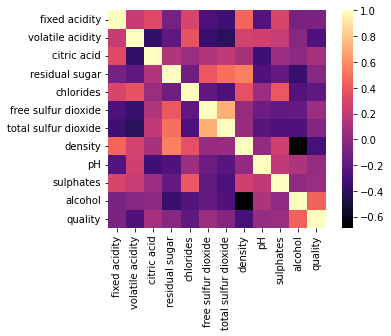

In [45]:
dfwithoutType = df.drop('Type', 1)

corr = dfwithoutType.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        square=True,
        cmap="magma")


Graficam el valor que prenen les característiques númeriques del dataframe mitjançant un histograma

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

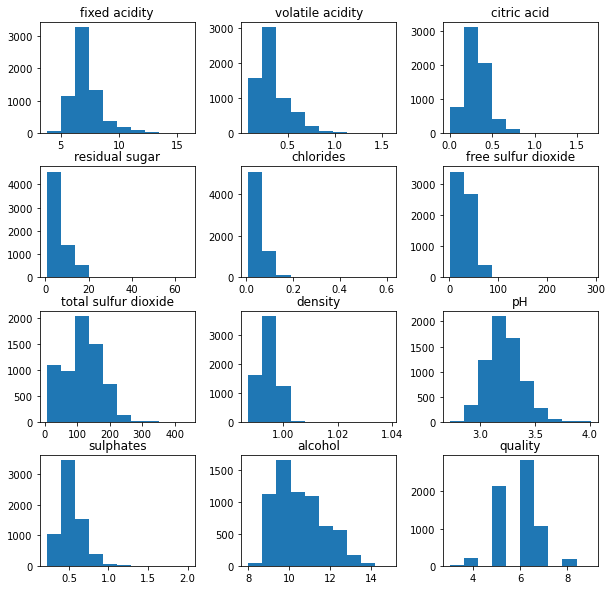

In [44]:
dfwithoutType.hist(figsize=(10,10), grid=False)


Gràfic cirular amb el que podem veure la proporció de vi blanc i vermell

1    75.388641
0    24.611359
Name: Type, dtype: float64


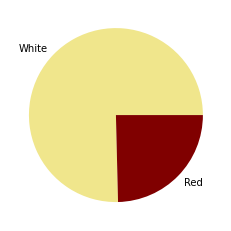

In [50]:
plt.pie(df['Type'].value_counts(), labels = ["White","Red"], colors=["khaki","Maroon"])
print(df['Type'].value_counts(normalize=True)*100)


# Classificadors

## Regressió Logística

Hem decidit donar-li valor al hiperparàmetre max_iters perquè amb el valor per defecte no arribava a convergir.

In [ ]:
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train,y_train)

y_predict = logreg.predict(X_test)

print(classification_report(y_test, y_predict))

training_accuracy = logreg.score(X_train,y_train)
print('training_accuracy:',training_accuracy)

testing_accuracy = logreg.score(X_test,y_test)
print('testing_accuracy:',testing_accuracy)

## Perceptró

In [ ]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train)

y_predict=perceptron.predict(X_test)

print(classification_report(y_test, y_predict))

training_accuracy = perceptron.score(X_train,y_train)
print('training_accuracy:',training_accuracy)

testing_accuracy = perceptron.score(X_test,y_test)
print('testing_accuracy:',testing_accuracy)

## Random Forest

Hem decidit donar-li valor al hiperparàmetre max_depth perquè amb el valor per defecte teniem overfitting.

In [ ]:
rf = RandomForestClassifier(max_depth=14)
rf.fit(X_train, y_train)

y_predict=rf.predict(X_test)

print(classification_report(y_test, y_predict))

training_accuracy = rf.score(X_train,y_train)
print('training_accuracy:',training_accuracy)

testing_accuracy = rf.score(X_test,y_test)
print('testing_accuracy:',testing_accuracy)

## Conclusions
Blablabla

# Engineria de característiques